## Scientific Computing 2023: Homework Assignment 1
Due Sunday October 15, 2023, 23:59

### Problem 1 (2 points)
Under assumptions of Amdahl's law, suppose that 75% of a program are perfectly parallelizable, and the rest is not parallelizable.
1. What is the maximum speedup achievable by parallelization?
2. Suppose that we have obtained speedup 2 (by using a suitable number of processes). What is the efficiency of this parallelization?

### Answer 1
#### Amdahl's Law
## $S = \frac{1}{s+\frac{1-s}{P}}$
$P$ - Number of processors \
$S$ - Work done sequentially

1. Applying the formula from the lectures, with $s = 1 - 0.75 = 0.25$ we get:
   #### $S = \frac{1}{0.25+\frac{0.75}{P}} = \frac{1}{\frac{1}{4} + \frac{3}{4P}} = \frac{1}{\frac{P+3}{4P}} = \frac{4P}{P+3} $

   For: \
   $P = 10$, $S = 3.077$
    
   $P = 100$, $S = 3,883$
   
   $P = 1000$, $S = 3,988$

   #### $\lim_{P \to \infty} \frac{4P}{P+3} = 4$
   <br>
2. Efficiency (E) is how efficient the parallelization is using available resources and is given by
    #### $E = \frac{S}{P}$

   Solving Amdahl's Law for $S = 2$, we get $P = 3$. Therefore, $E = \frac{2}{3} \sim  0.67 $

### Problem 2 (2 points)
Write a Python or C/C++ program that uses **MPI reduce** to find the largest file in terms of the  number of lines among all .txt files in the working directory (only .txt files should be examined). The program must be callable in the form `mpirun -np <N> python linecount.py` (in the case of the Python version) or `mpirun -np <N> linecount.exe` (the C/C++ version), where `<N>` is the user-defined number of processes. The program is expected to first somehow distribute the files found in the current directory to the processes, then each process should count the lines in the files assigned to it, and finally the result should be MPI-reduced and printed out. The program only needs to output **the number of lines in the largest file**; no need to output the name of this file. The program must work correctly even if the number of files is not divisible by the number of processes.


In [ ]:
!pip install mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 15.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.5-cp310-cp310-linux_x86_64.whl size=2746495 sha256=4adfb53a617e5a59bcd1e552976ae26ffdc321f0c31525e3ee0f3073d2ea451b
  Stored in directory: /root/.cache/pip/wheels/18/2b/7f/c852523089e9182b45fca50ff56f49a51eeb6284fd25a66713
Successfully built mpi4py


In [ ]:
import os
import sys
from mpi4py import MPI

def count_lines(filename):
    with open(filename, 'r') as file:
        return sum(1 for line in file)

def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    if len(sys.argv) != 2:
        if rank == 0:
            print("Usage: mpirun -np <N> python linecount.py <directory>")
        sys.exit(1)

    directory = sys.argv[1]

    if rank == 0:
        txt_files = [f for f in os.listdir(directory) if f.endswith('.txt')]
    else:
        txt_files = None

    txt_files = comm.bcast(txt_files, root=0)
    num_files = len(txt_files)

    files_per_process = num_files // size
    remainder = num_files % size

    start_idx = rank * files_per_process + min(rank, remainder)
    end_idx = start_idx + files_per_process + (1 if rank < remainder else 0)

    max_lines = 0
    local_max_lines = 0

    for idx in range(start_idx, end_idx):
        file_path = os.path.join(directory, txt_files[idx])
        line_count = count_lines(file_path)
        local_max_lines = max(local_max_lines, line_count)

    max_lines = comm.reduce(local_max_lines, op=MPI.MAX, root=0)

    if rank == 0:
        print(f"Maximum number of lines in {sys.argv[1]}/*.txt files: {max_lines}")

if __name__ == "__main__":
    main()


**How to run:**


1.   Create a `linecount.py` file inside the current directory and copy the code above into it.
2.   Create `files` directory inside the current directory and create files with `.txt` extension and different total line numbers.
3.   Run the cell below  



In [ ]:
!mpirun --allow-run-as-root --oversubscribe -np 4 python linecount.py files

Maximum number of lines in files/*.txt files: 22



### Problem 3 (2 points)
Solve the Distinct Substrings problem at Sphere online judge: http://www.spoj.com/problems/DISUBSTR/. Provide code passing the test of the judge. Explain how your code works and theoretically estimate the complexity of the algorithm (as $O(f(N))$, where $f(N)$ is some function of the length of the input string). (Note: Sphere may require a VPN connection. If for some reason you cannot use VPN, you can solve a similar problem at the judge DMOJ that does not require VPN: https://dmoj.ca/problem/ccc03s4; note however that this judge does not support numpy. Indicate in your solution which version of the problem you were solving.)


Solving **DISUBSTR - Distinct Substrings** on Sphere online judge

**To run on colab:**
- Create a file and name it `Makefile`
- Copy and paste the text in the cell below to the `Makefile` file
- Create a file called `disubstr.cpp`
- Copy and paste the C++ code into the `disubstr.cpp` file

```python
SRC = disubstr.cpp
BIN = disubstr.out
C++FLAGS = -o $(BIN) -std=c++17 -O3 -Wall
C++ =  g++
DATE = $(shell date +%d/%m/%y)
#COMPUTER ?= Desktop

.PHONY: all compile run clean

all: clean compile

compile:
	@echo " *  Compiling"
	-$(C++) $(SRC) $(C++FLAGS)
	@echo " *  Created on: $(DATE)"
	@echo " *  Author: Aksoy Tevfik Oguzhan"

run:
	./$(BIN)

clean:
	rm -rf $(BIN)
```




```cpp
#include <algorithm>
#include <cstring>
#include <ctime>
#include <iomanip>
#include <iostream>
#include <vector>

constexpr int MAXL = 1024;  // Max length of the string
constexpr int MAXP = 12;    // Max power of 2

// Arrays to store the string at each level and the inverse of the suffix array
int stringLevels[MAXP][MAXL], inverseSuffixArray[MAXL];

// Node of the suffix array, storing index and two ranks
class SuffixNode {
 public:
  int index;
  int ranks[2];

  void display() {
    std::cout << "Index: " << index << std::endl;
    std::cout << "Ranks: ";
    for (auto& i : ranks) {
      std::cout << i << ", ";
    }
    std::cout << std::endl;
  }
};

// Suffix array
SuffixNode suffixArray[MAXL];

// Number of steps or powers of 2 and length of the string
int currentStep, stringLength;

// Compare function to compare two SuffixNodes
bool compareSuffixNodes(const SuffixNode& a, const SuffixNode& b) {
  return a.ranks[0] == b.ranks[0] ? (a.ranks[1] < b.ranks[1])
                                  : (a.ranks[0] < b.ranks[0]);
}

/* The function starts by initializing the first level of stringLevels with the
 * ASCII values of the characters in the input string. It then enters a loop
 * that constructs the suffix array using the prefix doubling algorithm. This
 * algorithm involves sorting the suffixes based on their ranks at each step.
 * For each suffix, it calculates two ranks: one based on the characters at the
 * current position and another based on the characters after moving to the next
 * level (doubling the step size). After sorting the suffixes, it updates the
 * ranks for the current level and stores these ranks in stringLevels. The loop
 * continues until reaching the power of 2 larger than the string length.*/
void SA(const std::string& inputString) {
  // Initialize the first level with the ASCII values of the characters in the
  // string
  for (size_t i = 0; i < inputString.length(); i++)
    stringLevels[0][i] = inputString[i];

  // Loop until we reach the power of 2 larger than the string length
  currentStep = 1;
  stringLength = inputString.length();

  for (int step = 1; (1 << (step - 1)) < stringLength; step++, currentStep++) {
    // Loop over all suffixes
    for (int j = 0; j < stringLength; j++) {
      // First half will be the first rank the one which we have already sorted
      suffixArray[j].ranks[0] = stringLevels[currentStep - 1][j];

      // Next half will be second rank and other suffix which we have already
      // sorted in previous step for this k = 4, 2 and 2 length strings are
      // already sorted
      int nextHalfIndex = j + (1 << (step - 1));
      suffixArray[j].ranks[1] =
          (nextHalfIndex < stringLength)
              ? stringLevels[currentStep - 1][nextHalfIndex]
              : -1;

      // Store the current index as it will change after sorting
      suffixArray[j].index = j;
    }

    // Sort the suffix array based on ranks
    std::sort(suffixArray, suffixArray + stringLength, compareSuffixNodes);

    // Add new ranks of this level to each suffix
    for (int j = 0; j < stringLength; j++) {
      int prevIndex = suffixArray[j].index;
      int prevRank1 = suffixArray[j].ranks[0];
      int prevRank2 = suffixArray[j].ranks[1];

      int prevRankIndex = (j > 0) ? suffixArray[j - 1].index : -1;
      int prevRank1Prev = (j > 0) ? suffixArray[j - 1].ranks[0] : -1;
      int prevRank2Prev = (j > 0) ? suffixArray[j - 1].ranks[1] : -1;

      // If the current suffix has same rank as previous one then do not
      // increase its rank Else increase it or make it equal to current j.
      stringLevels[currentStep][prevIndex] =
          (step > 0 &&
           (prevRank1 == prevRank1Prev && prevRank2 == prevRank2Prev))
              ? stringLevels[currentStep][prevRankIndex]
              : j;
    }
  }
}

/* The LCP function calculates the longest common prefix between two suffixes by
 * comparing their ranks in the stringLevels array. It iteratively checks if the
 * prefixes at each level (from highest to lowest power of 2) are equal and
 * increases the length of the common prefix accordingly. */
int LCP(int x, int y) {
  // if both are less than x return
  if (x < 0 || y < 0)
    return 0;

  // Loop until the power becomes 0 or numbers become greater than length
  // As extreme cases in search of binary search
  int result = 0;
  for (int k = currentStep - 1; k >= 0 && x < stringLength && y < stringLength;
       k--) {
    // If the prefixes at current power are equal
    // Increase the x and y values after the equal
    // prefixes. if they are at 0 and 0 and k is 4
    // increase than to 4 and 4 as first 4 characters are equal
    // According to level,now find the next 2 one if they are
    // equal or not.
    if (stringLevels[k][x] == stringLevels[k][y]) {
      x += (1 << k);
      y += (1 << k);
      result += (1 << k);
    }
  }

  return result;
}

/* The main function first reads the number of test cases.
 * For each test case, it reads an input string and initializes the data
 * structures. It then constructs the suffix array and computes the inverse of
 * the suffix array (i.e., a mapping from index to rank). After constructing the
 * suffix array and inverse, it calculates the total number of distinct
 * substrings. This is done by iterating through the suffixes in the sorted
 * order and subtracting the LCP of consecutive suffixes from the total string
 * length.
 * */
int main() {
  int numTestCases;
  std::cin >> numTestCases;
  std::vector<int> results;

  std::string inputString;

  double time_taken_sa = 0;
  double time_taken_invd = 0;

  auto start_total = clock();

  while (numTestCases--) {
    std::cin >> inputString;

    // Initialize all variables
    memset(stringLevels, 0, sizeof(stringLevels));
    memset(suffixArray, 0, sizeof(suffixArray));
    memset(inverseSuffixArray, 0, sizeof(inverseSuffixArray));

    currentStep = 0;

    auto start = clock();
    // Find the suffix array
    SA(inputString);
    auto stop = clock() - start;
    time_taken_sa += ((double)stop / CLOCKS_PER_SEC);

    start = clock();
    // Find the inverse of suffix array
    for (int i = 0; i < stringLength; i++)
      inverseSuffixArray[stringLevels[currentStep - 1][i]] = i;

    // Find the lcp of consecutive suffixes as it will give how many characters
    // can make distinct substring.
    int totalDistinctSubstrings = stringLength - suffixArray[0].index;
    for (int i = 1; i < stringLength; i++) {
      // Subtract from total length of current suffix the lcp of this and
      // previous one
      totalDistinctSubstrings +=
          (stringLength - suffixArray[i].index) -
          LCP(inverseSuffixArray[i - 1], inverseSuffixArray[i]);
    }
    stop = clock() - start;
    time_taken_invd += ((double)stop / CLOCKS_PER_SEC);

    results.emplace_back(totalDistinctSubstrings);
  }

  for (auto& result : results) {
    std::cout << result << std::endl;
  }

  auto stop_total = clock() - start_total;
  double total_time = ((double)stop_total) / CLOCKS_PER_SEC;

  std::cout << std::fixed;

  std::cout << "Time to construct SA: " << time_taken_sa << " s" << std::endl;
  std::cout << "Time to find inverse SA and total distinct substrings: "
            << time_taken_invd << " s" << std::endl;
  std::cout << "Total execution time: " << total_time << " s" << std::endl;

  return 0;
}

```



In [ ]:
!make

rm -rf disubstr.out
 *  Compiling
g++ disubstr.cpp -o disubstr.out -std=c++17 -O3 -Wall
 *  Created on: 15/10/23
 *  Author: Aksoy Tevfik Oguzhan


In [ ]:
!make run

./disubstr.out
2
CCCCC
ABABA
5
9
Time to construct SA: 0.000007 s
Time to find inverse SA and total distinct substrings: 0.000002 s
Total execution time: 0.000264 s


The most time-consuming part of the code is the construction of the suffix array using the SA function, which was discussed together with LCP throughout the lab. The time complexity of constructing the suffix array is approximately $O(N * log^2(N))$, where N is the length of the input string. This is because constructing the SA involves nested loops, and it iterates $log(N)$ times, each time performing comparisons and updates that are linear in the length of the string.

In the main driver function, there is a loop over test cases, which adds a factor of $T$ (number of test cases).

The time complexity of the entire code is $O(T * N * log^2(N))$, where T is the number of test cases and N is the length of the longest input string among all test cases.

In summary, the code constructs the suffix array for a given string and uses it to calculate the total number of distinct substrings. The time complexity is $O(T * N * log^2(N))$, where T is the number of test cases, and $N$ is the length of the input string.


### Problem 4 (2 points)
Suppose that we want to distribute $N$ personal projects to $N$ students. Assume that each student $(k)_{k=0}^{N-1}$ has a list of his/her preferences for the projects, expressed as a vector $\mathbf r_k$ of integer ranks assigned to each project. Ranks vary between 0 and $N-1$ without repetitions, the **lower** the rank the **more preferable** the project. (For example, the first student's ranks are $\mathbf r_0 = [2,1,0]$, the second's $\mathbf r_1 = [0,2,1]$ and the third $\mathbf r_2 = [0,1,2]$). We want to distribute the projects so as to maximize the total preference, i.e., if $n_k$ denotes the project assigned to the $k$'th student, we want to make $f = \sum_{k=0}^{N-1} \mathbf r_k[n_k]$ as small as possible. (In the example above the optimal distribution is $n_0=2, n_1=0, n_2=1$, which gives $f=1$).  
  * Come up with an algorithm optimizing the distribution and implement it in a Python or C/C++ program. The algorithm should accept the preference vectors and output a recommended distribution $(n_k)_{k=1}^N$. The algorithm need not find the best solution, but is expected to generally produce better solutions than would have been obtained by randomly distributing the projects. The algorithm should be reasonably fast, say run in not more than a few seconds for $N=30$.
  * Compare experimentally your algorithm with the trivial algorithm producing a random distribution. To this end, perform $M=1000$ experiments in each of which 1) random preference vectors for $N=30$ students and projects are generated; 2) the objective function $f$ is evaluated for both algorithms. After finishing all the experiments, plot the two respective distributions of the obtained $M$ values of $f$ and compute the mean values of $f$ for both algorithms.


N: 30
The total cost of the distribution is 23
Time elapsed for 1 iteration: 0.01387119 s.
Total time elapsed: 10.969528913497925 s.
Mean recommended: 13.346
Mean random: 434.435


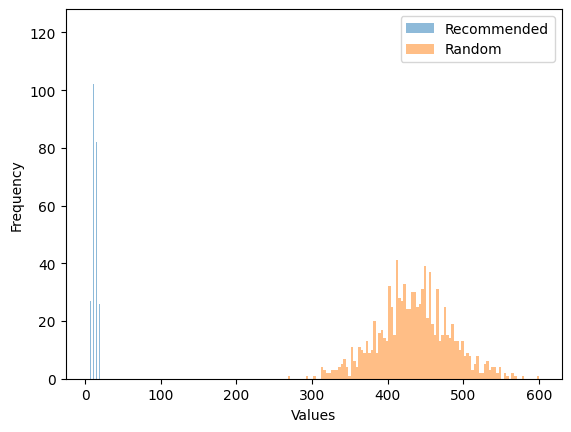

In [ ]:
import numpy as np
import sys
import time
import random
import matplotlib.pyplot as plt
from copy import copy, deepcopy

M = 1000
recommended_costs = np.zeros(M, dtype=int)
random_costs = np.zeros(M, dtype=int)

# Define a function to take input preferences for student-project assignments
def take_input():
    preferences = []  # Initialize an empty list to store preferences

    try:
      # Sys args input doesn't work in colab, in order to run, please copy everything to a new file
      # and uncomment necessary parts
        #N = int(sys.argv[1])  # Try to read the first command-line argument as the number of students or projects
        N = int(input("N: "))
        preferences = np.asarray([np.random.choice(np.arange(0, N), replace=False, size=(N)) for _ in range(N)])
        # Generate a random preferences matrix based on the given number
        assert preferences.shape == (N, N), "Preferences matrix is wrong!"  # Check if the matrix is square
    except:
      pass
    """
    except IndexError:
        print("Enter one argument (either a number to randomly generate preferences or a .txt file)")
        # If no command-line argument is provided, print an error message and exit
        exit(1)
    except ValueError:
        file = sys.argv[1]  # Read the first command-line argument as a file name
        with open(file, "r") as f:
            # Open the file for reading
            preferences = np.asarray([[int(i) for i in j.replace("\n", "").split(",")] for j in f.readlines()])
            # Read preferences from the file and convert them to a NumPy array

            assert preferences.shape[0] == preferences.shape[1], "Preferences matrix must be square!"
    """
        # Check if the matrix read from the file is square

    return preferences.shape[0], preferences  # Return the size (N) and the preferences matrix


def mark_matrix(mat):
    current_matrix = mat  # Make a copy of the input matrix
    zero_bool_mat = (current_matrix == 0)  # Create a boolean matrix to identify zeros
    zero_bool_mat_copy = zero_bool_mat.copy()  # Create a copy of the boolean matrix

    marked_zero = []  # List to store coordinates of marked zeros
    while (True in zero_bool_mat_copy):  # Continue until there are unmarked zeros
        min_row = [99999, -1]  # Initialize variables to track the minimum row

        for row_num in range(zero_bool_mat_copy.shape[0]):
            if np.sum(zero_bool_mat_copy[row_num] == True) > 0 and min_row[0] > np.sum(zero_bool_mat_copy[row_num] == True):
                # Find the row with the fewest unmarked zeros
                min_row = [np.sum(zero_bool_mat_copy[row_num] == True), row_num]

        zero_index = np.where(zero_bool_mat_copy[min_row[1]] == True)[0][0]  # Find the first unmarked zero in the row
        marked_zero.append((min_row[1], zero_index))  # Mark the row and column of the zero
        zero_bool_mat_copy[min_row[1], :] = False  # Mark the row as processed
        zero_bool_mat_copy[:, zero_index] = False  # Mark the column as processed

    marked_zero_row = []  # List to store row indexes with marked zeros
    marked_zero_col = []  # List to store column indexes with marked zeros
    for i in range(len(marked_zero)):
        marked_zero_row.append(marked_zero[i][0])
        marked_zero_col.append(marked_zero[i][1])

    non_marked_row = list(set(range(current_matrix.shape[0])) - set(marked_zero_row))
    # Find rows without marked zeros

    marked_cols = []  # List to store column indexes with marked zeros
    check_switch = True
    while check_switch:
        check_switch = False
        for i in range(len(non_marked_row)):
            row_array = zero_bool_mat[non_marked_row[i], :]
            for j in range(row_array.shape[0]):
                if row_array[j] == True and j not in marked_cols:
                    marked_cols.append(j)
                    check_switch = True

        for row_num, col_num in marked_zero:
            if row_num not in non_marked_row and col_num in marked_cols:
                non_marked_row.append(row_num)
                check_switch = True

    marked_rows = list(set(range(mat.shape[0])) - set(non_marked_row))
    # Find rows with marked zeros

    return (marked_zero, marked_rows, marked_cols)  # Return marked zeros, marked rows, and marked columns


def step(mat):
    for row_num in range(mat.shape[0]):
        mat[row_num] = mat[row_num] - np.min(mat[row_num])
    # Subtract the minimum value of each row from the entire row

    for col_num in range(mat.shape[1]):
        mat[:, col_num] = mat[:, col_num] - np.min(mat[:, col_num])
    # Subtract the minimum value of each column from the entire column

    return mat  # Return the matrix after performing the step


def set_matrix(mat, cover_rows, cover_cols):
    current_matrix = mat
    non_zero_element = []

    # Collect non-zero elements not covered by marked rows or columns
    for row in range(len(current_matrix)):
        if row not in cover_rows:
            for i in range(len(current_matrix[row])):
                if i not in cover_cols:
                    non_zero_element.append(current_matrix[row][i])

    min_num = min(non_zero_element)

    # Subtract the minimum non-zero element from uncovered elements in rows
    for row in range(len(current_matrix)):
        if row not in cover_rows:
            for i in range(len(current_matrix[row])):
                if i not in cover_cols:
                    current_matrix[row, i] = current_matrix[row, i] - min_num

    # Add the minimum non-zero element to covered elements in rows and columns
    for row in range(len(cover_rows)):
        for col in range(len(cover_cols)):
            current_matrix[cover_rows[row], cover_cols[col]] = current_matrix[cover_rows[row], cover_cols[col]] + min_num

    return current_matrix

def student_project_distribution(cost_matrix):
    n = cost_matrix.shape[0]
    current_matrix = deepcopy(cost_matrix)

    current_matrix = step(current_matrix)

    count_zero_lines = 0

    # Continue marking rows and columns until all rows or columns have zeros
    while count_zero_lines < n:
        ans_pos, marked_rows, marked_cols = mark_matrix(current_matrix)
        count_zero_lines = len(marked_rows) + len(marked_cols)

        # Set the matrix to cover marked rows and columns
        if count_zero_lines < n:
            current_matrix = set_matrix(current_matrix, marked_rows, marked_cols)

        return ans_pos


def plot(*args):
    plt.hist(recommended_costs, bins=100, alpha=0.5, label='Recommended')
    plt.hist(random_costs, bins=100, alpha=0.5, label='Random')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


N, preferences = take_input()

start_all = time.time()

for i in range(M):
    if i == 0: start = time.time()
    distribution = student_project_distribution(preferences)
    if i == 0:
        end = time.time()
        if preferences.shape[0] < 15:
          print(preferences)

    total = 0
    for val in distribution:
        if i == 0 and preferences.shape[0] < 15: print(f"Student {val[0]+1} is assigned to Project #{val[1]+1}.")
        total += preferences[val[0], val[1]]

    recommended_costs[i] = total

    for j in range(N):
        np.random.shuffle(preferences[j])

    if i == 0: print(f"The total cost of the distribution is {total}")
    if i == 0: print(f"Time elapsed for 1 iteration: {end-start:.8f} s.")

    tmp_preferences = copy(preferences)

    for j in range(N):
        col = random.randint(0, tmp_preferences.shape[1]-1)
        random_costs[i] += tmp_preferences[j][col]
        tmp_preferences = np.delete(tmp_preferences, col, 1)

print(f"Total time elapsed: {time.time() - start_all} s.")

mean_rec = recommended_costs.mean()
mean_ran = random_costs.mean()

print(f"Mean recommended: {mean_rec}")
print(f"Mean random: {mean_ran}")

plot(recommended_costs, random_costs)

  
### Problem 5 (2 points)
Suppose that we have developed an algorithm that is supposed to generate independent (quasi-)random numbers uniformly distributed in the interval $[0,1]$. To test our algorithm, we perform a series of experiments. In each experiment, we generate $N=10^3$ numbers $(x_n)_{n=1}^N$ with our algorithm, and compute the minimum distance $r=\min_{1 \le n < m\le N}|x_n-x_m|$ between them. We observe that in more than 99% of such experiments we obtain $r < 10^{-5}$. Does this observation contradict the hypothesis of generating independent uniformly distributed random numbers? Explain your answer.

In [44]:
import random, time

def rng(N):
    random_numbers = [random.random() for _ in range(N)]
    return random_numbers

def find_r(random_numbers):
    random_numbers.sort()
    min_distance = min(random_numbers[i+1] - random_numbers[i] for i in range(len(random_numbers) - 1))
    return min_distance

M = 100000
total = 0
start = time.time()
for _ in range(M):
  N = 1000
  random_numbers = rng(N)
  min_distance = find_r(random_numbers)
  total += min_distance

print(f"In {M} experiments, the mean minimum distance (r) is: {total/M}")
print(f"Total time the experiment took: {time.time() - start} s.")

In 100000 experiments, the mean minimum distance (r) is: 9.97844207769748e-07
Total time the experiment took: 43.10380005836487 s.


No, the observation that in more than 99% of experiments we obtain a minimum distance between randomly generated numbers less than $10^{-5}$ does not contradict the hypothesis of generating independent uniformly distributed random numbers. In fact, it is consistent with the properties of random numbers.

Considering $N=10^3$, the probability of two randomly generated numbers being very close to each other ($|x_n - x_m| < 10^{-5}$ for some $n < m$) is not negligible, even if the numbers are generated independently and uniformly.

The probability of two random numbers being very close to each other ($|x_n - x_m| < 10^{-5}$) in a sequence of $N$ random numbers can be calculated by considering the total number of ways we can choose two numbers from $N$ and the number of ways we can choose two numbers such that their difference is less than $10^{-5}$.

$P(|x_n - x_m| < 10^{-5}) = \frac{\text{Number of ways to choose two close numbers}}{\text{Total number of ways to choose two numbers}}$

Calculation of choosing two close numbers can be done by integrating the uniform probability density function. And total number of ways to choose two numbers is basically ${n \choose 2}$.